In [4]:
pip install particle hepunits vector

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
pt                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
eta                  | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
phi                  | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
mass                 | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
charge               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
energy               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
px                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
py                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pz                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pdgId                | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
status               | std::

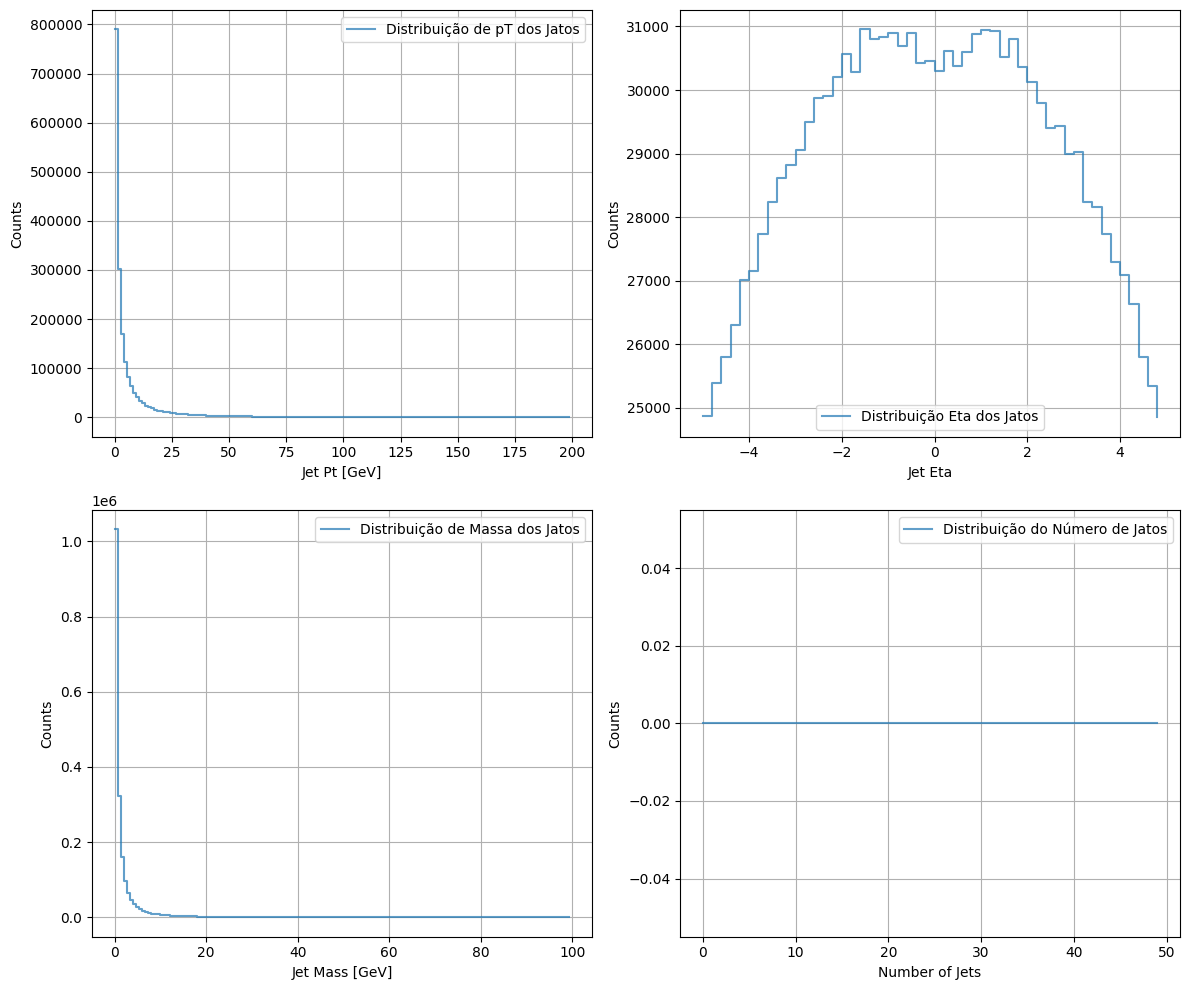

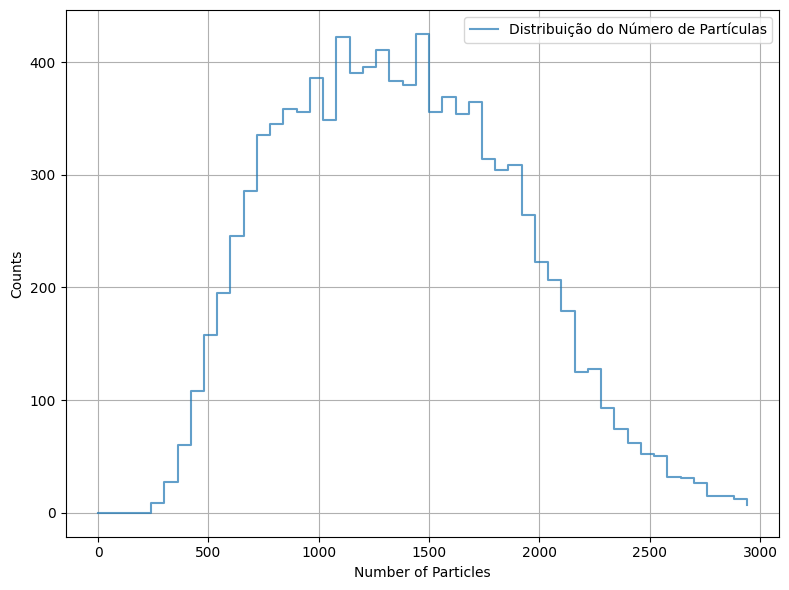

In [5]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import hist
import fastjet
import particle
from hepunits import GeV
import vector
import time

vector.register_awkward()

def create_histograms():
    histograms = {
        # Histogramas dos jatos
        "hist_jet_pt": hist.Hist.new.Reg(150, 0, 200).Int64(),
        "hist_jet_eta": hist.Hist.new.Reg(50, -5, 5).Int64(),
        "hist_jet_mass": hist.Hist.new.Reg(150, 0, 100).Int64(),
        # Novo: Histogramas para o número de jatos e número de partículas
        "hist_num_jets": hist.Hist.new.Reg(50, 0, 50).Int64(),  # Número de jatos por evento
        "hist_num_particles": hist.Hist.new.Reg(50, 0, 3000).Int64(),  # Número de partículas usadas no clustering
    }
    return histograms

def pt(px, py):
    return np.sqrt(px**2 + py**2)

def eta(px, py, pz, e):
    p = np.sqrt(px**2 + py**2 + pz**2)
    return 0.5 * np.log((e + pz) / (e - pz))

def mass(px, py, pz, e):
    return np.sqrt(e**2 - (px**2 + py**2 + pz**2))

def plot_hist(ax, hist_obj, xlabel, ylabel, title):
    edges = hist_obj.axes[0].edges
    values = hist_obj.values()
    ax.step(edges[:-1], values, where='post', alpha=0.7, label=title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)

# Abrir o arquivo ROOT
tree = uproot.open("events4.root")["Events"]
tree.show()

# Transferir os eventos do arquivo para awkward arrays
events = tree.arrays(library="ak")

# Criar a coleção de partículas
particles = ak.zip({"px": events.px, 
                    "py": events.py, 
                    "pz": events.pz, 
                    "e": events.energy, 
                    "pt": events.pt, 
                    "eta": events.eta, 
                    "phi": events.phi, 
                    "id": events.pdgId, 
                    "charge": events.charge,
                    "status": events.status}, 
                    with_name="particle")

# Criar histogramas
histograms = create_histograms()

# Filtrar partículas (exemplo para muons e b-quarks, mas não será usado diretamente no clustering de jatos)
muons = particles[np.abs(particles.id) == 13]
bquarks = particles[np.abs(particles.id) == 5]

# Definir clustering de jatos com fastjet
# Converting particles to fastjet pseudojets (using 0 mass for simplicity)
probable_mass = particle.Particle.from_name("pi+").mass / GeV  # Aproximação para partículas com massa pequena
pseudojets = ak.zip(
    {"px": particles.px, "py": particles.py, "pz": particles.pz, "mass": probable_mass}, with_name="Momentum4D"
)

# Filtrando jatos com pT > 0.1 GeV
good_pseudojets = pseudojets[pseudojets.pt > 0.1]

# Definir o jet clustering usando o algoritmo anti-kt com R=0.4
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.4)

# Clustering com fastjet
clusterseq = fastjet.ClusterSequence(good_pseudojets, jetdef)
jets = clusterseq.inclusive_jets()

# Para os jatos, coletar informações como pT, eta e massa
jet_pts = ak.flatten([jet.pt for jet in jets])
jet_etas = ak.flatten([jet.eta for jet in jets])
jet_masses = ak.flatten([jet.m for jet in jets])

# Preencher histogramas dos jatos
histograms["hist_jet_pt"].fill(jet_pts)
histograms["hist_jet_eta"].fill(jet_etas)
histograms["hist_jet_mass"].fill(jet_masses)

# Preencher o histograma para o número de jatos
num_jets = ak.num(jets)
histograms["hist_num_jets"].fill(num_jets)

# Preencher o histograma para o número de partículas usadas no clustering
num_particles = ak.num(good_pseudojets)
histograms["hist_num_particles"].fill(num_particles)

# Print time taken
start_time = time.time()
print(f"Time to run: {(time.time() - start_time)} seconds")

# Plotar os histogramas dos jatos
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Histogramas dos jatos
plot_hist(ax[0, 0], histograms["hist_jet_pt"], 'Jet Pt [GeV]', 'Counts', 'Distribuição de pT dos Jatos')
plot_hist(ax[0, 1], histograms["hist_jet_eta"], 'Jet Eta', 'Counts', 'Distribuição Eta dos Jatos')
plot_hist(ax[1, 0], histograms["hist_jet_mass"], 'Jet Mass [GeV]', 'Counts', 'Distribuição de Massa dos Jatos')
plot_hist(ax[1, 1], histograms["hist_num_jets"], 'Number of Jets', 'Counts', 'Distribuição do Número de Jatos')

plt.tight_layout()
plt.show()

# Plotar os histogramas do número de partículas
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_hist(ax, histograms["hist_num_particles"], 'Number of Particles', 'Counts', 'Distribuição do Número de Partículas')

plt.tight_layout()
plt.show()


In [11]:
import uproot

# Caminho para o arquivo ROOT
file_path = "events4.root"

# Abrindo o arquivo ROOT
with uproot.open(file_path) as file:
    # Inspecionando o conteúdo de 'Events;15'
    events_15 = file["Events;15"]
    print("Conteúdo de 'Events;15':")
    print(events_15.keys())
    
    # Inspecionando o conteúdo de 'Events;14'
    events_14 = file["Events;14"]
    print("\nConteúdo de 'Events;14':")
    print(events_14.keys())


Conteúdo de 'Events;15':
['pt', 'eta', 'phi', 'mass', 'charge', 'energy', 'px', 'py', 'pz', 'pdgId', 'status']

Conteúdo de 'Events;14':
['pt', 'eta', 'phi', 'mass', 'charge', 'energy', 'px', 'py', 'pz', 'pdgId', 'status']


In [25]:
import uproot

# Caminho para o arquivo ROOT
file_path = "events4.root"

# Abrindo o arquivo ROOT
with uproot.open(file_path) as file:
    # Listando todas as chaves no arquivo
    print("Chaves no arquivo ROOT:")
    print(file.keys())



Chaves no arquivo ROOT:
['Events;15', 'Events;14', 'nJets;1', 'pTjets;1', 'yJets;1', 'phiJets;1', 'distJets;1', 'pTdiff;1', 'invMassJets;1', 'numParticlesInJets;1']


Conteúdo do arquivo ROOT: ['Events;15', 'Events;14', 'nJets;1', 'pTjets;1', 'yJets;1', 'phiJets;1', 'distJets;1', 'pTdiff;1', 'invMassJets;1', 'numParticlesInJets;1']


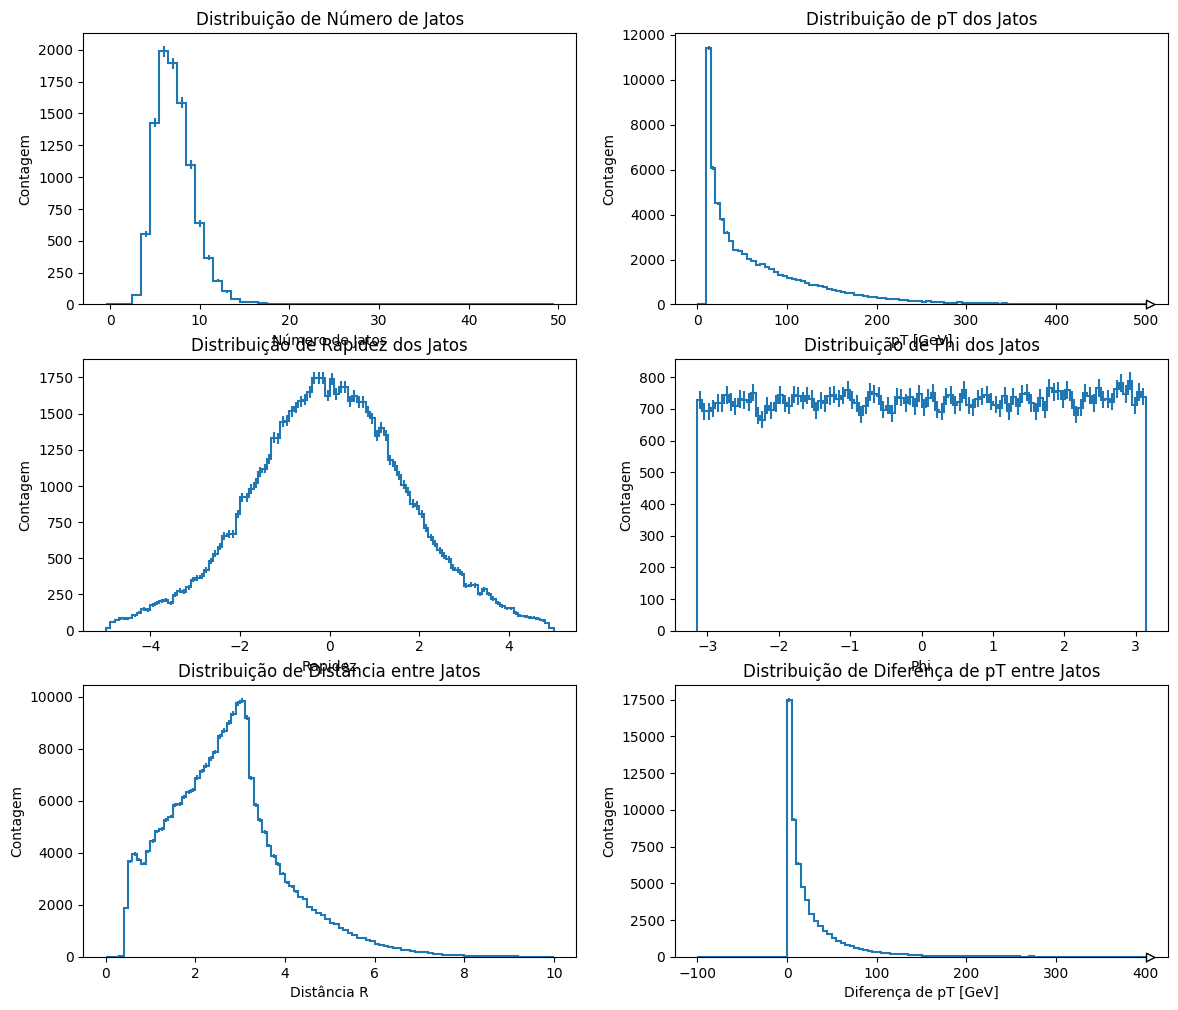

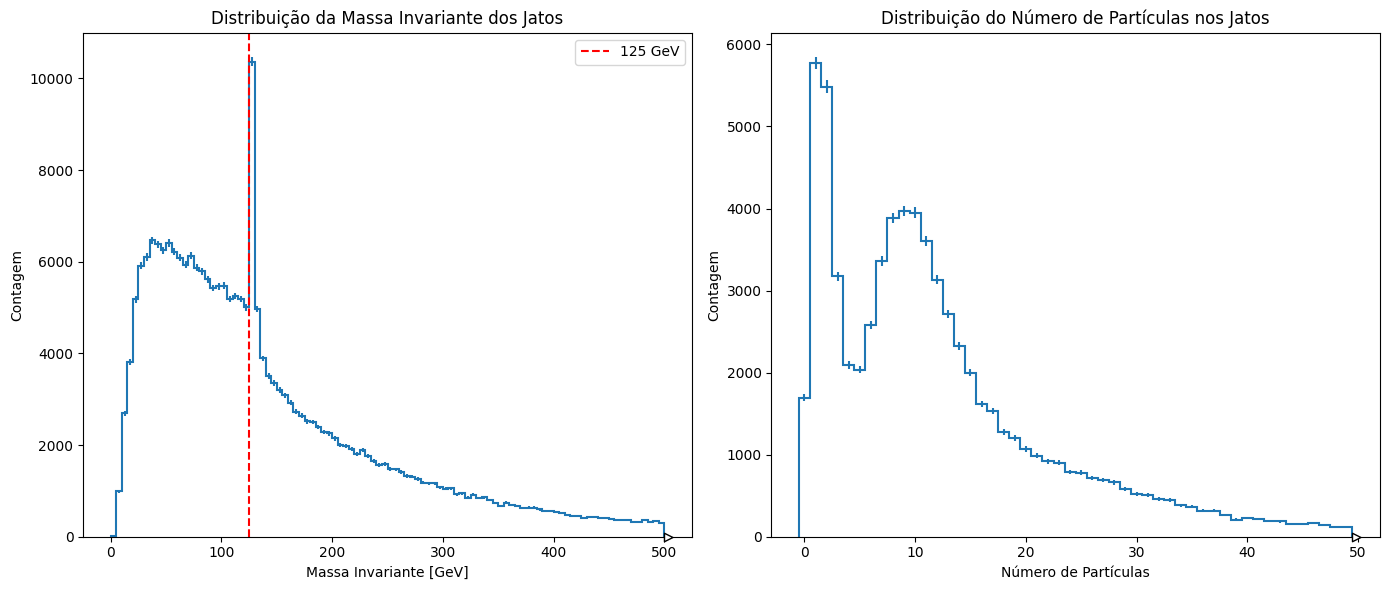

In [28]:
import uproot
import matplotlib.pyplot as plt

# Abrir o arquivo ROOT
file = uproot.open("events4.root")

# Exibir as chaves do arquivo para verificar os nomes corretos dos histogramas
print("Conteúdo do arquivo ROOT:", file.keys())

# Abrir os histogramas utilizando a função to_hist()
nJets_hist = file["nJets;1"].to_hist()
pTjets_hist = file["pTjets;1"].to_hist()
yJets_hist = file["yJets;1"].to_hist()
phiJets_hist = file["phiJets;1"].to_hist()
distJets_hist = file["distJets;1"].to_hist()
pTdiff_hist = file["pTdiff;1"].to_hist()
invMassJets_hist = file["invMassJets;1"].to_hist()  # Novo histograma para a massa invariante dos jatos
numParticlesInJets_hist = file["numParticlesInJets;1"].to_hist()  # Novo histograma para número de partículas nos jatos

# Plotar todos os histogramas
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# Plotar os histogramas com ajustes manuais para título e rótulos
nJets_hist.plot(ax=axs[0, 0])
axs[0, 0].set_title('Distribuição de Número de Jatos')
axs[0, 0].set_xlabel('Número de Jatos')
axs[0, 0].set_ylabel('Contagem')

pTjets_hist.plot(ax=axs[0, 1])
axs[0, 1].set_title('Distribuição de pT dos Jatos')
axs[0, 1].set_xlabel('pT [GeV]')
axs[0, 1].set_ylabel('Contagem')

yJets_hist.plot(ax=axs[1, 0])
axs[1, 0].set_title('Distribuição de Rapidez dos Jatos')
axs[1, 0].set_xlabel('Rapidez')
axs[1, 0].set_ylabel('Contagem')

phiJets_hist.plot(ax=axs[1, 1])
axs[1, 1].set_title('Distribuição de Phi dos Jatos')
axs[1, 1].set_xlabel('Phi')
axs[1, 1].set_ylabel('Contagem')

distJets_hist.plot(ax=axs[2, 0])
axs[2, 0].set_title('Distribuição de Distância entre Jatos')
axs[2, 0].set_xlabel('Distância R')
axs[2, 0].set_ylabel('Contagem')

pTdiff_hist.plot(ax=axs[2, 1])
axs[2, 1].set_title('Distribuição de Diferença de pT entre Jatos')
axs[2, 1].set_xlabel('Diferença de pT [GeV]')
axs[2, 1].set_ylabel('Contagem')

# Plotar os dois novos histogramas
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotar o histograma da massa invariante dos jatos
invMassJets_hist.plot(ax=axs[0])
axs[0].set_title('Distribuição da Massa Invariante dos Jatos')
axs[0].set_xlabel('Massa Invariante [GeV]')
axs[0].set_ylabel('Contagem')

# Adicionar uma linha vertical em 125 GeV
axs[0].axvline(x=125, color='r', linestyle='--', label="125 GeV")

# Adicionar uma legenda para a linha
axs[0].legend()

# Plotar o histograma do número de partículas nos jatos
numParticlesInJets_hist.plot(ax=axs[1])
axs[1].set_title('Distribuição do Número de Partículas nos Jatos')
axs[1].set_xlabel('Número de Partículas')
axs[1].set_ylabel('Contagem')

# Ajustar o layout e exibir o gráfico
plt.tight_layout()
plt.show()
